# Variational Autoencoder (VAE)

This notebook contains an implementation of a Variational Autoencoder (VAE) using PyTorch. The VAE is trained on the CIFAR-10 dataset to generate new images.

### Import libraries

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

from torch import Tensor

## Loading The Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CIFAR10(
    root='../../datasets',
    train=True,
    download=False,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

1. **Encoder Class**: 
    - The `Encoder` class is a neural network module that encodes input images into a latent space. It uses convolutional layers to extract features and fully connected layers to produce the mean and log variance of the latent variables.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_d=20, in_channels=1, hidden_channels=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=4, stride=2, padding=1)

        self.input_features = hidden_channels * 4 * 4 * 4 # for Cifar10 dataset

        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(self.input_features, latent_d)
        self.fc_logvar = nn.Linear(self.input_features, latent_d)

    def forward(self, x: Tensor):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = self.flatten(x)
        
        mean = self.fc_mean(x)
        log_var = self.fc_logvar(x)
        return mean, log_var

2. **Decoder Class**: 
    - The `Decoder` class is a neural network module that decodes latent variables back into images. It uses transposed convolutional layers to reconstruct the images from the latent space.

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_d=20, in_channels=1, hidden_channels=32):
        super().__init__()
        self.convT1 = nn.ConvTranspose2d(4 * hidden_channels, 2 * hidden_channels, kernel_size=4, stride=2, padding=1)
        self.convT2 = nn.ConvTranspose2d(2 * hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.convT3 = nn.ConvTranspose2d(hidden_channels, in_channels, kernel_size=4, stride=2, padding=1)

        self.hidden_channels = hidden_channels

        self.dc = nn.Linear(latent_d, 4 * hidden_channels * 4 * 4)

    def forward(self, x: Tensor):
        x = self.dc(x)
        x = x.view(x.size(0), 4 * self.hidden_channels, 4, 4)
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))

        return F.sigmoid(self.convT3(x))

## 3. Variational Autoencoder (VAE)

A Variational Autoencoder (VAE) is a type of generative model that learns a probabilistic mapping between a latent space and observed data. The key idea is to model the data as coming from a distribution, rather than learning a fixed mapping.

- **Encoder**: The encoder maps the input data $ \mathbf{x} $ into a probabilistic distribution over the latent space, typically a Gaussian with parameters (mean $ \mu $ and standard deviation $ \sigma $).
- **Decoder**: The decoder then samples from this latent distribution and reconstructs the data.

In a VAE, the encoder outputs the parameters of the latent distribution (mean $ \mu $ and log-variance $ \log(\sigma^2) $) rather than a fixed encoding.

## The Reparameterization Trick

One of the key challenges in training VAEs is that sampling from a distribution (such as a Gaussian) is not differentiable, which is required for backpropagation. This is where the **Reparameterization Trick** comes in.

### Reparameterization Trick

Given a random variable $ z $ from a Gaussian distribution $ \mathcal{N}(\mu, \sigma^2) $, we can write it as:

$$
z = \mu + \sigma \cdot \epsilon
$$

where $ \epsilon \sim \mathcal{N}(0, 1) $ is a standard normal random variable (mean 0 and variance 1), and $ \mu $ and $ \sigma $ are the parameters learned by the encoder.

### Why This Works

This trick is useful because it allows us to move the sampling operation out of the graph of the model, making the process differentiable. By rewriting the latent variable $ z $ as a function of $ \mu $, $ \sigma $, and a random variable $ \epsilon $, we can backpropagate through the network and update the parameters $ \mu $ and $ \sigma $.

Thus, during training, the VAE learns to parameterize the Gaussian distribution, and the reparameterization trick enables gradient descent to optimize the model. The key advantage is that the network can still learn to optimize its parameters even though we are sampling from a probability distribution.

### Mathematical Expression

The reparameterization trick can be summarized as:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, 1)
$$

This allows backpropagation through the latent variable $ z $, and thus, the parameters $ \mu $ and $ \sigma $ can be learned effectively.

By using this trick, we can sample from the latent distribution in a way that is differentiable and allows us to train the model using standard optimization methods like stochastic gradient descent.

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_d=20, in_channels=1, hidden_channels=32):
        super().__init__()
        self.encoder = Encoder(latent_d, in_channels, hidden_channels)
        self.decoder = Decoder(latent_d, in_channels, hidden_channels)

    def forward(self, x: Tensor):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        z = z.view(z.size(0), -1)
        recon = self.decoder(z)
        return recon, mean, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

4. **Loss Function**: 
    - The `vae_loss` function calculates the loss for the VAE, which is a combination of reconstruction loss (binary cross-entropy) and KL divergence loss.

### Loss Function for Variational Autoencoder (VAE)

The loss function for a Variational Autoencoder (VAE) is a combination of two terms: the reconstruction loss and the KL divergence loss.

The total VAE loss is given by:

$$ \text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence Loss} $$

Where:
$$ \text{Reconstruction Loss} = \sum_{i} \left( x_i \log(x_{\text{recon}, i}) + (1 - x_i) \log(1 - x_{\text{recon}, i}) \right) $$

$$ \text{KL Divergence Loss} = -\frac{1}{2} \sum_{j} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right) $$

In [6]:
def vae_loss(x_recon, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction="sum")
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss

Set the device

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

5. **Training Loop**: 
    - The training loop trains the VAE on the CIFAR-10 dataset. It iterates over the dataset, performs forward and backward passes, and updates the model parameters using the Adam optimizer.

In [8]:
vae = VAE(20, 3, 32).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 15

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader.dataset):.4f}")

  7%|▋         | 1/15 [00:12<02:56, 12.62s/it]

Epoch [1/15], Loss: 1959.9888


 13%|█▎        | 2/15 [00:22<02:20, 10.83s/it]

Epoch [2/15], Loss: 1867.1201


 20%|██        | 3/15 [00:31<02:03, 10.27s/it]

Epoch [3/15], Loss: 1845.8686


 27%|██▋       | 4/15 [00:41<01:48,  9.91s/it]

Epoch [4/15], Loss: 1840.4201


 33%|███▎      | 5/15 [00:50<01:37,  9.77s/it]

Epoch [5/15], Loss: 1838.9209


 40%|████      | 6/15 [01:00<01:27,  9.71s/it]

Epoch [6/15], Loss: 1837.6122


 47%|████▋     | 7/15 [01:09<01:17,  9.68s/it]

Epoch [7/15], Loss: 1837.2024


 53%|█████▎    | 8/15 [01:19<01:07,  9.59s/it]

Epoch [8/15], Loss: 1836.0554


 60%|██████    | 9/15 [01:28<00:57,  9.57s/it]

Epoch [9/15], Loss: 1835.6548


 67%|██████▋   | 10/15 [01:38<00:47,  9.58s/it]

Epoch [10/15], Loss: 1835.2155


 73%|███████▎  | 11/15 [01:47<00:38,  9.58s/it]

Epoch [11/15], Loss: 1834.7761


 80%|████████  | 12/15 [01:57<00:28,  9.55s/it]

Epoch [12/15], Loss: 1834.3855


 87%|████████▋ | 13/15 [02:07<00:19,  9.62s/it]

Epoch [13/15], Loss: 1834.0719


 93%|█████████▎| 14/15 [02:16<00:09,  9.59s/it]

Epoch [14/15], Loss: 1833.6251


100%|██████████| 15/15 [02:26<00:00,  9.76s/it]

Epoch [15/15], Loss: 1833.7821


6. **Image Generation**: 
    - The `generate_images` function generates new images by sampling from the latent space and passing the samples through the decoder. It visualizes the generated images using Matplotlib.

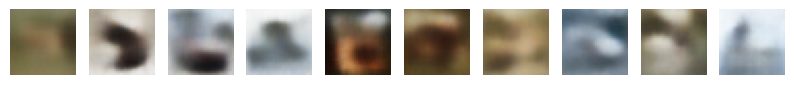

In [12]:
def generate_images(model, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, 20)
        samples = model.decoder(z.to(device)).view(num_samples, 3, 32, 32)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i].permute(1, 2, 0).cpu().numpy())
        ax.axis("off")
    plt.show()

generate_images(vae, 10)

# Reasons for Blurry Images in Variational Autoencoders (VAEs)

The blurry images generated by Variational Autoencoders (VAEs) are a well-known issue in generative modeling. This happens due to several factors inherent to the VAE architecture, especially in how it models the latent space and handles reconstruction. Let’s break down the reasons:

## 1. Smooth Latent Space
In VAEs, the encoder learns a **probabilistic distribution** (usually Gaussian) over the latent variables rather than directly learning a single point in the latent space. Specifically, the encoder outputs a **mean** and a **variance** for each latent variable, which defines a Gaussian distribution.

- **Sampling from this distribution** introduces noise and smoothness into the latent space. 
- When generating an image, we sample from this latent space and pass the sample through the decoder. The decoder doesn't have a direct mapping to a unique point but rather reconstructs an image based on a sampled point, which could lie in a smooth region of the latent space.

This **smooth latent space** doesn't allow for sharp and distinct features, contributing to the **blurriness** of generated images. The generated image is typically a mixture of different possible reconstructions, leading to **averaging** of features and **blurred outputs**.

## 2. Gaussian Assumption for Latent Variables
In a VAE, we assume that the latent variables follow a **Gaussian distribution** (i.e., the mean and variance learned by the encoder are used to sample from a standard normal distribution). However, **Gaussian distributions are unimodal**, meaning they don't model complex, high-dimensional data distributions very well, especially in cases where the data (e.g., images) has **discrete or sharp features** (like edges or fine details).

This Gaussian prior induces a **smooth latent space** that doesn’t capture fine-grained details well. When sampled, the decoder reconstructs images that are an average over multiple possible configurations, leading to a blurry output.

## 3. Reconstruction Loss (MSE)
In VAEs, the **reconstruction loss** (usually mean squared error or MSE) is used to compare the original image with the reconstructed image. MSE encourages the model to minimize the **overall pixel-wise differences** between the original and generated image.

- MSE, being a **pixel-wise loss**, tends to **favor blurry images** because the model can reduce the error by averaging over neighboring pixels. This can result in sharp details (such as edges or textures) being smeared out.
- This averaging effect in pixel-wise reconstruction is one of the reasons for blurry outputs.

## 4. Limited Capacity of the Decoder
The **decoder network** (which generates images from the latent variables) might not always have enough capacity to capture high-frequency details like fine textures or sharp edges, especially if the latent space is smooth or if the decoder is relatively shallow. 

This undercapacity can result in blurry images because the model cannot reconstruct fine details.

## 5. Stochastic Nature of Latent Space Sampling
VAEs use the **reparameterization trick** to sample latent variables. The latent variables are sampled from a distribution defined by the mean and variance output by the encoder. Since this is a probabilistic process, there can be a **loss of information** during sampling, leading to blurry or imprecise reconstructions.

## 6. Lack of Explicit Modeling of Fine Details
VAEs don't explicitly model fine details or high-frequency components of the image. Since VAEs are trained to model the **global distribution of data** rather than individual sharp features, they tend to generate images that are **visually plausible but lack sharpness**.

## How to Improve Image Quality in VAEs
- **Use of more sophisticated loss functions**: To counteract the blurriness, one could switch from pixel-wise loss functions (like MSE) to more perceptual losses, such as those based on features extracted from pre-trained models like VGG. **Adversarial training** (using a GAN loss) has been successfully combined with VAEs to improve the sharpness of generated images.
  
- **Better architecture**: Instead of using a simple fully connected network as the decoder, you can use **convolutional networks**, which are more capable of generating fine details and sharper features in images.

- **Latent space regularization**: You could experiment with techniques like **disentangled VAEs** or **β-VAE**, which improve how the latent space captures the variability in the data.

- **Higher dimensional latent space**: Increasing the dimensionality of the latent space may allow the model to capture more complex variations in the data, potentially leading to sharper reconstructions.

## Conclusion
The blurriness in VAE-generated images is primarily due to the **smoothness** of the latent space induced by the **Gaussian prior**, the **reparameterization trick**, and the **pixel-wise reconstruction loss**. While VAEs are great for learning generative models, their design favors smooth, averaged reconstructions, which can lead to blurry images.